Converted water_aimd_1ns_every0.5fs-pos-1.xyz to water.pdb
Number of O-O pairs: 4032


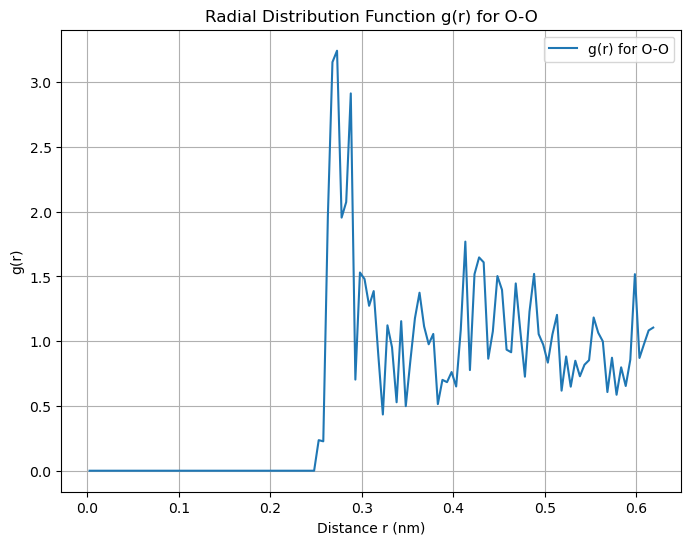

Number of O-H pairs: 8192


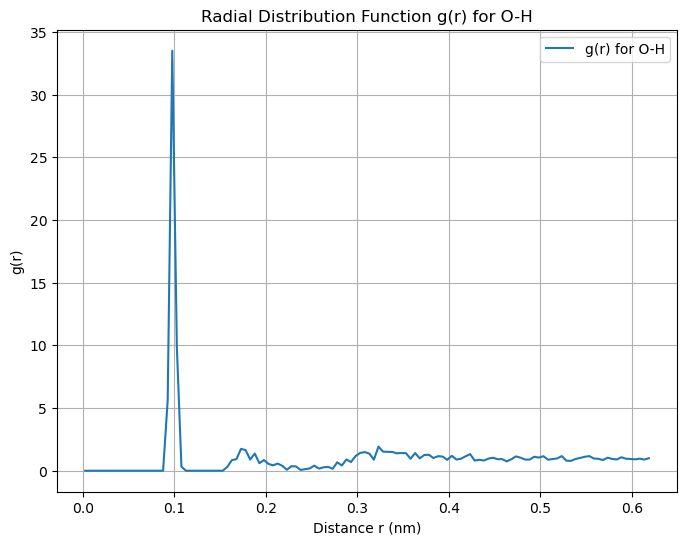

In [17]:
import mdtraj as md
import matplotlib.pyplot as plt

def xyz_to_pdb(xyz_file, pdb_file, box_size=None):
    """
    Convert an XYZ file to a PDB file.

    Parameters:
    - xyz_file: str - Path to the input XYZ file.
    - pdb_file: str - Path to the output PDB file.
    - box_size: tuple - Box dimensions (a, b, c) in Ångstroms.
    """
    with open(xyz_file, 'r') as xyz, open(pdb_file, 'w') as pdb:
        lines = xyz.readlines()
        num_atoms = int(lines[0].strip())  # First line: number of atoms

        # Write box dimensions if provided
        if box_size:
            pdb.write(f"CRYST1{box_size[0]:9.3f}{box_size[1]:9.3f}{box_size[2]:9.3f}  90.00  90.00  90.00 P 1           1\n")

        # Convert XYZ lines to PDB format
        pdb.write(f"TITLE     Converted from {xyz_file}\n")
        pdb.write("MODEL        1\n")
        for i, line in enumerate(lines[2:2+num_atoms], start=1):
            parts = line.split()
            element, x, y, z = parts[0], float(parts[1]), float(parts[2]), float(parts[3])
            pdb.write(f"HETATM{i:5d}  {element:<2}  MOL     1    {x:8.3f}{y:8.3f}{z:8.3f}  1.00  0.00           {element:<2}\n")
        pdb.write("ENDMDL\n")
        pdb.write("END\n")
    print(f"Converted {xyz_file} to {pdb_file}")

def compute_pair_gr(traj_file, top_file, atom1, atom2, box_size, output_file):
    """
    Compute and plot the radial distribution function (g(r)) for specific atom pairs.

    Parameters:
    - traj_file: str - Trajectory file (e.g., PDB format).
    - top_file: str - Topology file (e.g., PDB format).
    - atom1: str - First atom type (e.g., "O", "H").
    - atom2: str - Second atom type (e.g., "H", "H").
    - box_size: float - Box size (nm).
    - output_file: str - Output file name for the graph (.png).
    """
    # Load trajectory
    traj = md.load(traj_file, top=top_file)

    # Select atoms of the specified types
    indices1 = [atom.index for atom in traj.topology.atoms if atom.element.symbol == atom1]
    indices2 = [atom.index for atom in traj.topology.atoms if atom.element.symbol == atom2]

    # Generate pairs of selected atoms
    pairs = [(i, j) for i in indices1 for j in indices2 if i != j]
    print(f"Number of {atom1}-{atom2} pairs: {len(pairs)}")

    # Compute g(r)
    rdf, edges = md.compute_rdf(traj, pairs=pairs, r_range=(0, box_size / 2))
    r = edges[:len(rdf)]  # r values matching rdf length

    # Plot g(r)
    plt.figure(figsize=(8, 6))
    plt.plot( rdf,r, label=f"g(r) for {atom1}-{atom2}")
    plt.xlabel("Distance r (nm)")
    plt.ylabel("g(r)")
    plt.title(f"Radial Distribution Function g(r) for {atom1}-{atom2}")
    plt.legend()
    plt.grid()
    plt.savefig(output_file)
    plt.show()

# Example Workflow

# Step 1: Convert XYZ to PDB
xyz_file = "water_aimd_1ns_every0.5fs-pos-1.xyz"
pdb_file = "water.pdb"
box_size = (12.42, 12.42, 12.42)  # Box dimensions in Ångstroms
xyz_to_pdb(xyz_file, pdb_file, box_size)

# Step 2: Compute RDF
# Box size in nm for MDTraj
compute_pair_gr("water.pdb", "water.pdb", "O", "O", 1.242, "gr_oxygen_oxygen.png")
compute_pair_gr("water.pdb", "water.pdb", "O", "H", 1.242, "gr_oxygen_hydrogen.png")
